In [ ]:
%load_ext autoreload
%autoreload 2

import json
import os
import pickle
from multiprocessing import Pool
from pathlib import Path
from time import gmtime, strftime, time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from utils import TPScoringFunction, calc_auc, ecfp, score

def timestamp():
    return strftime("%Y-%m-%d_%H:%M:%S", gmtime())


# chid = 'CHEMBL1909140'
chid='CHEMBL1909203'

n_estimators=100
n_jobs=8

# read data and calculate ecfp fingerprints
assay_file = f'./assays/processed/{chid}.csv'
print(f'Reading data from: {assay_file}')
df = pd.read_csv(assay_file)
X = np.array(ecfp(df.smiles))
y = np.array(df.label)

# split in equally sized sets. Stratify to get same label distributions
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, stratify=y)

balance = (np.mean(y1), np.mean(y2))

def rf_base():
    return  RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs)

from sklearn.linear_model import LogisticRegression
def lr_base():
    return LogisticRegression()
from sklearn.svm import SVC

def svm_base():
    return SVC(gamma='auto', probability=True)

from sklearn.neural_network import MLPClassifier
def mlp_base():
    return MLPClassifier()

from sklearn.ensemble import GradientBoostingClassifier
def boost_base():
    return GradientBoostingClassifier()

clf_base = rf_base
# clf_base = lr_base
# clf_base = svm_base
# clf_base = MLPClassifier
# clf_base = boost_base

# train classifiers and store them in dictionary
clfs = {}
clfs['Split1'] = clf_base()
clfs['Split1'].fit(X1, y1)

clfs['Split1_alt'] = clf_base()
clfs['Split1_alt'].fit(X1, y1)

clfs['Split2'] = clf_base()
clfs['Split2'].fit(X2, y2)

# calculate AUCs for the clfs
aucs = {}
aucs['Split1'] = calc_auc(clfs['Split1'], X2, y2)
aucs['Split1_alt'] = calc_auc(clfs['Split1_alt'], X2, y2)
aucs['Split2'] = calc_auc(clfs['Split2'], X1, y1)
print("AUCs:")
for k, v in aucs.items():
    print(f'{k}: {v}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading data from: ./assays/processed/CHEMBL1909203.csv
AUCs:
Split1: 0.7682668329177058
Split1_alt: 0.8339152119700748
Split2: 0.7041770573566084


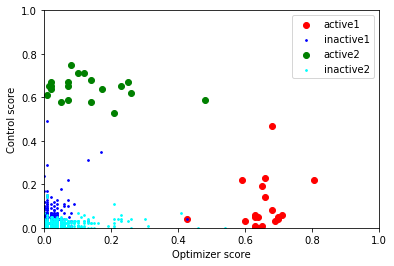

In [ ]:
p11 = clfs['Split1'].predict_proba(X1)[:,1]
p21 = clfs['Split2'].predict_proba(X1)[:,1]

p12 = clfs['Split1'].predict_proba(X2)[:,1]
p22 = clfs['Split2'].predict_proba(X2)[:,1]

import seaborn as sns


idx1 = np.array(y1, bool)
idx2 = np.array(y2, bool)
plt.scatter(p11[idx1], p21[idx1], c='red', label='active1')
plt.scatter(p11[~idx1], p21[~idx1], c='blue', label='inactive1', s=3)
plt.scatter(p12[idx2], p22[idx2], c='green', label='active2')
plt.scatter(p12[~idx2], p22[~idx2], c='cyan', label='inactive2', s=3)
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('Optimizer score')
plt.ylabel('Control score')
plt.legend()

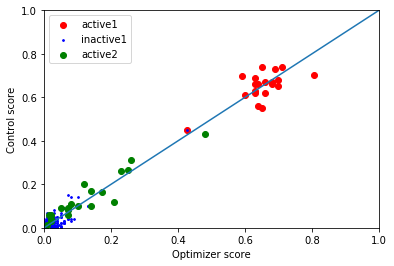

In [ ]:
p11 = clfs['Split1'].predict_proba(X1)[:,1]
p21 = clfs['Split1_alt'].predict_proba(X1)[:,1]

p12 = clfs['Split1'].predict_proba(X2)[:,1]
p22 = clfs['Split1_alt'].predict_proba(X2)[:,1]

import seaborn as sns


idx1 = np.array(y1, bool)
idx2 = np.array(y2, bool)
plt.scatter(p11[idx1], p21[idx1], c='red', label='active1')
plt.scatter(p11[~idx1], p21[~idx1], c='blue', label='inactive1', s=3)
plt.scatter(p12[idx2], p22[idx2], c='green', label='active2')A
# plt.scatter(p12[~idx2], p22[~idx2], c='cyan', label='inactive2', s=3)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0,1],[0,1])
plt.xlabel('Optimizer score')
plt.ylabel('Control score')
plt.legend()

In [ ]:
# def optimize(chid,
#              n_estimators,
#              n_jobs,
#              external_file,
#              n_external,
#              seed,
#              optimizer_args):


chid='CHEMBL3888429'
n_estimators=100
n_jobs=8
external_file='./data/guacamol_v1_test.smiles'
n_external=3000
seed=101

    
np.random.seed(seed)
# config = locals()
# print(locals())
#set up logging

In [ ]:
results_dir = os.path.join('./test', 'lstm_hc', chid, timestamp())
os.makedirs(results_dir)

In [ ]:
# config_file = os.path.join(results_dir, 'config.json')
# with open(config_file, 'w') as f:
#     json.dump(config, f)



clfs, aucs, balance, X1, X2,y1,y2 = fit_clfs(chid, n_estimators, n_jobs)
results = {}
results['AUC'] = aucs
results['balance'] = balance

clf_file = os.path.join(results_dir, 'classifiers.p')
with open(clf_file, 'wb') as f:
    pickle.dump(clfs, f)

Reading data from: ./assays/processed/CHEMBL3888429.csv
AUCs:
Split1: 0.8218614718614718
Split1_alt: 0.8124458874458874
Split2: 0.8033948940793046


In [ ]:
from guacamol_baselines.graph_ga.goal_directed_generation import GB_GA_Generator

optimizer_args=dict(smi_file='./data/guacamol_v1_train.smiles',
                    population_size=100,
                    offspring_size=200,
                    generations=3,
                    mutation_rate=0.01,
                    n_jobs=-1,
                    random_start=True,
                    patience=5,
                    canonicalize=False)

optimizer = GB_GA_Generator(**optimizer_args)
smiles_history = optimizer.generate_optimized_molecules(scoring_function, 100, get_history=True)

selecting initial population...
0 | max: 0.383 | avg: 0.263 | min: 0.197 | std: 0.050 | sum: 26.287 | 4.46 sec/gen | 22.40 mol/sec | 0.89 rest 
1 | max: 0.481 | avg: 0.299 | min: 0.240 | std: 0.050 | sum: 29.879 | 1.51 sec/gen | 66.35 mol/sec | 0.97 rest 
2 | max: 0.511 | avg: 0.336 | min: 0.275 | std: 0.049 | sum: 33.565 | 1.56 sec/gen | 64.18 mol/sec | 1.05 rest 


In [ ]:
from guacamol_baselines.smiles_lstm_hc.smiles_rnn_directed_generator import SmilesRnnDirectedGenerator

# Create guacamol scoring function with clf trained on split 1
scoring_function = TPScoringFunction(clfs['Split1'])

optimizer_args = dict(pretrained_model_path = './guacamol_baselines/smiles_lstm_hc/pretrained_model/model_final_0.473.pt',
                        n_epochs = 150,
                        mols_to_sample = 1028,
                        keep_top = 512,
                        optimize_n_epochs = 1,
                        max_len = 100,
                        optimize_batch_size = 64,
                        number_final_samples = 1028,
                        sample_final_model_only = False,
                        random_start = True,
                        smi_file = './data/guacamol_v1_train.smiles',
                        n_jobs = -1,
                        canonicalize=False)

# run optimization
t0 = time()
optimizer = SmilesRnnDirectedGenerator(**optimizer_args)
final_mols, smiles_history = optimizer.generate_optimized_molecules(scoring_function, 100, get_history=True)

selecting initial population...
Top 4:
	0.495: Cc1c(NC(=O)c2ccc(S(=O)(=O)N3CCCCCC3)cc2)c(=O)n(-c2ccccc2)n1C
	0.475: N#Cc1ccc(C(=O)Nc2ccc(C=Cc3ccnc4ccccc34)cc2)cc1
	0.465: COP(=O)(OC)C(OC(=O)COc1ccc(C#N)cc1)c1cccs1
	0.423: CC1(O)CC(C(=O)N2CC=C(c3ccc(C(=O)NC(=N)N)cc3C(F)(F)F)CC2)C(c2ccc(Cl)c(F)c2)C1
Top 4:
	0.495: Cc1c(NC(=O)c2ccc(S(=O)(=O)N3CCCCCC3)cc2)c(=O)n(-c2ccccc2)n1C
	0.475: N#Cc1ccc(C(=O)Nc2ccc(C=Cc3ccnc4ccccc34)cc2)cc1
	0.465: COP(=O)(OC)C(OC(=O)COc1ccc(C#N)cc1)c1cccs1
	0.460: CN(CC(CCN1CCC2(CC1)CS(=O)(=O)c1ccccc12)c1ccc(Cl)c(Cl)c1)S(=O)(=O)c1cccs1
Top 4:
	0.495: Cc1c(NC(=O)c2ccc(S(=O)(=O)N3CCCCCC3)cc2)c(=O)n(-c2ccccc2)n1C
	0.485: O=c1c(-c2cccc(F)c2)nc2cncnc2n1Cc1ccccc1F
	0.475: N#Cc1ccc(C(=O)Nc2ccc(C=Cc3ccnc4ccccc34)cc2)cc1
	0.465: COP(=O)(OC)C(OC(=O)COc1ccc(C#N)cc1)c1cccs1
Top 4:
	0.537: N#Cc1ccc(-c2csc(NN=Cc3cccnc3)n2)cc1
	0.521: CN1CCN(S(=O)(=O)c2ccc(C(=O)Nc3ccc(Cl)c(S(=O)(=O)Nc4ccc(C#N)cc4)c3)cc2)CC1
	0.500: N#Cc1ccc(N2CCN(c3nc(Nc4cncnc4)nc(N4CCN(c5ccc(C(=O)O)cc5)CC4)n3)CC2

In [ ]:
def can_list(smiles):
    ms = [Chem.MolFromSmiles(s) for s in smiles]
    return [Chem.MolToSmiles(m) for m in ms if m is not None]

smiles_history = [can_list(e) for e in smiles_history]

min_length = min(len(e) for e in smiles_history)
smiles_history = [e[:min_length] for e in smiles_history]

In [ ]:
# make a list of dictionaries for every time step
from rdkit import Chem
from tqdm import tqdm_notebook, tqdm
statistics = []
for optimized_smiles in tqdm(smiles_history):
    row = {}
    row['smiles'] = optimized_smiles
    print(sum(1 for s in optimized_smiles if Chem.MolFromSmiles(s)))
    row['preds'] = {}
    for k, clf in clfs.items():
        preds = score(optimized_smiles, clf)
        print(sum(1 for s in preds if s is not None))
        row['preds'][k] = preds
    statistics.append(row)

results['statistics'] = statistics





  0%|          | 0/15 [00:00<?, ?it/s]

787
787
787






  7%|▋         | 1/15 [00:03<00:46,  3.35s/it]

787
787
787
787






 13%|█▎        | 2/15 [00:06<00:43,  3.37s/it]

787
787
787
787






 20%|██        | 3/15 [00:10<00:40,  3.36s/it]

787
787
787
787






 27%|██▋       | 4/15 [00:13<00:37,  3.39s/it]

787
787
787
787






 33%|███▎      | 5/15 [00:16<00:33,  3.37s/it]

787
787
787
787






 40%|████      | 6/15 [00:20<00:30,  3.40s/it]

787
787
787
787






 47%|████▋     | 7/15 [00:23<00:27,  3.40s/it]

787
787
787
787






 53%|█████▎    | 8/15 [00:27<00:23,  3.40s/it]

787
787
787
787






 60%|██████    | 9/15 [00:30<00:20,  3.40s/it]

787
787
787
787






 67%|██████▋   | 10/15 [00:34<00:17,  3.44s/it]

787
787
787
787






 73%|███████▎  | 11/15 [00:37<00:13,  3.48s/it]

787
787
787
787






 80%|████████  | 12/15 [00:41<00:10,  3.45s/it]

787
787
787
787






 87%|████████▋ | 13/15 [00:44<00:06,  3.46s/it]

787
787
787
787






 93%|█████████▎| 14/15 [00:47<00:03,  3.46s/it]

787
787
787
787






100%|██████████| 15/15 [00:51<00:00,  3.43s/it]

787


In [ ]:
with open(external_file) as f:
    external_smiles = f.read().split()[]
external_smiles = np.random.choice(external_smiles, n_external)
results['predictions_external'] = {k: score(external_smiles, clf) for k, clf in clfs.items()}

results_file = os.path.join(results_dir, 'results.json')
with open(results_file, 'w') as f:
    json.dump(results, f)

print(f'Storing results in {results_dir}')


Storing results in ./test/lstm_hc/CHEMBL3888429/2020-03-05_15:43:18


In [ ]:
import argparse
parser = argparse.ArgumentParser(description='Goal-directed generation benchmark for SMILES RNN',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--model_path', default=None, help='Full path to the pre-trained SMILES RNN model')
parser.add_argument('--max_len', default=100, type=int, help='Max length of a SMILES string')
parser.add_argument('--seed', default=42, type=int, help='Random seed')
parser.add_argument('--output_dir', default=None, help='Output directory for results')
parser.add_argument('--number_repetitions', default=1, type=int, help='Number of re-training runs to average')
parser.add_argument('--keep_top', default=512, type=int, help='Molecules kept each step')
parser.add_argument('--n_epochs', default=20, type=int, help='Epochs to sample')
parser.add_argument('--mols_to_sample', default=1024, type=int, help='Molecules sampled at each step')
parser.add_argument('--optimize_batch_size', default=256, type=int, help='Batch size for the optimization')
parser.add_argument('--optimize_n_epochs', default=2, type=int, help='Number of epochs for the optimization')
parser.add_argument('--benchmark_num_samples', default=4096, type=int,
                    help='Number of molecules to generate from final model for the benchmark')
parser.add_argument('--benchmark_trajectory', action='store_true',
                    help='Take molecules generated during re-training into account for the benchmark')
parser.add_argument('--smiles_file', default='data/guacamol_v1_all.smiles')
parser.add_argument('--random_start', action='store_true')
parser.add_argument('--n_jobs', type=int, default=-1)
parser.add_argument('--suite', default='v2')

args = parser.parse_args('')
for k,v in args.__dict__.items():
    print(f'{k} = {v},')
    
